# MobileNetV2-Based ASPP Residual SE U-Net for Fetal Head Segmentation
## Training Notebook (Google Colab Compatible)

**Platform:** Google Colab with GPU acceleration

### Architecture Overview

This notebook implements a **MobileNetV2-Based ASPP Residual SE U-Net** for efficient medical image segmentation with:

**Core Architecture:**
- **Encoder:** MobileNetV2 backbone (pre-trained on ImageNet, frozen for transfer learning)
- **Bottleneck:** ASPP module for multi-scale contextual feature extraction
- **Decoder:** 5 upsampling stages with ResidualBlockSE (trainable)
- **Skip Connections:** SE blocks applied before concatenation

**Key Innovations:**

1. **MobileNetV2 Encoder**: Efficient transfer learning
   - Pre-trained on ImageNet (frozen for fast training)
   - Depthwise separable convolutions (lightweight)
   - Feature extraction at 5 scales: [H/2, H/4, H/8, H/16, H/32]
   - ~70% of parameters frozen → reduced memory + faster training

2. **ASPP Module at Bottleneck**: Multi-scale contextual feature extraction
   - 1×1 convolution (point-wise features)
   - 3×3 atrous convolutions with dilation rates [6, 12, 18]
   - Global average pooling branch (image-level features)
   - Captures features at different scales simultaneously

3. **Squeeze-and-Excitation (SE) Blocks**: Channel-wise attention mechanism
   - Applied after every ResidualBlockSE in decoder
   - Applied to skip connections before concatenation
   - Learns to emphasize informative channels and suppress less useful ones
   - Reduction ratio: 16

4. **Residual Decoder Blocks**: Skip connections within blocks for better gradient flow

**Output:**
- **Raw logits** (no sigmoid activation in model)
- Sigmoid applied by loss function (BCEWithLogitsLoss) for numerical stability
- Compatible with DiceBCEWithLogitsLoss (combined Dice + BCEWithLogits loss)

**Advantages:**
- ✓ Efficient: MobileNetV2 uses depthwise separable convolutions
- ✓ Transfer Learning: Pre-trained weights from ImageNet
- ✓ Multi-scale Context: ASPP captures features at multiple scales
- ✓ Channel Attention: SE blocks enhance feature representation
- ✓ Numerically Stable: BCEWithLogitsLoss prevents overflow/underflow issues

## 1. Environment Setup

### Google Colab Configuration

**Repository:** `https://github.com/TrinhThaiSonDHQT/Fetal-Head-Segmentation`

**Directory Structure:**
- **Project Root:** `/content/Fetal-Head-Segmentation/`
- **Outputs:** `/content/outputs/results/`
  - Checkpoints, logs, predictions, and visualizations
  - Download results after training completes

**Steps:**
1. Clone repository from GitHub
2. Install dependencies (Albumentations 1.3.1)
3. Import required modules and verify CUDA availability

In [ ]:
# Clone the GitHub repository
import os

# Check if already cloned
if not os.path.exists('/content/Fetal-Head-Segmentation'):
    print("Cloning repository from GitHub...")
    !git clone https://github.com/TrinhThaiSonDHQT/Fetal-Head-Segmentation.git
    print("✓ Repository cloned successfully")
else:
    print("✓ Repository already exists")

Cloning repository from GitHub...
Cloning into 'Fetal-Head-Segmentation'...
remote: Enumerating objects: 12390, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 12390 (delta 19), reused 58 (delta 11), pack-reused 12313 (from 1)
Receiving objects: 100% (12390/12390), 1.20 GiB | 43.46 MiB/s, done.
Resolving deltas: 100% (400/400), done.
Updating files: 100% (15693/15693), done.
✓ Repository cloned successfully


In [ ]:
import os
import sys
from pathlib import Path

print("[Google Colab Setup]")

# Setup paths for Google Colab
project_root = Path('/content/Fetal-Head-Segmentation')
output_root = Path('/content/outputs')

# Verify project exists
if not project_root.exists():
    raise RuntimeError(
        f"Project not found at {project_root}\n"
        f"Please run the previous cell to clone the repository from GitHub."
    )

if not (project_root / 'efficient_focus').exists():
    raise RuntimeError(
        f"'efficient_focus' folder not found in {project_root}\n"
        f"Please ensure the repository was cloned correctly."
    )

print(f"Project root: {project_root}")
print(f"Output root: {output_root}")

# Add project to path
sys.path.insert(0, str(project_root))

print(f"\n✓ Environment setup complete")

[Google Colab Setup]
Project root: /content/Fetal-Head-Segmentation
Output root: /content/outputs

✓ Environment setup complete


In [ ]:
# Install required packages for Google Colab
print("Installing required packages...")

# Colab has most packages pre-installed (PyTorch, NumPy, Matplotlib, OpenCV)
# Pin Albumentations to 1.3.1 for compatibility with both Colab and Kaggle
!pip install -q albumentations==1.3.1

print("\n✓ Packages installed successfully")

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 7.0 MB/s eta 0:00:00

✓ Packages installed successfully


In [ ]:
import yaml
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Import from src directory
from src.losses import DiceBCEWithLogitsLoss
from src.models.variants.mobinet_aspp_residual_se.mobinet_aspp_residual_se import MobileNetV2ASPPResidualSEUNet, count_parameters
from src.data.dataset_v2 import LargeScaleDataset
from src.metrics.segmentation_metrics import dice_coefficient, iou_score, pixel_accuracy
from src.utils.visualization import save_prediction_grid, visualize_sample
from src.utils.transforms import get_transforms

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 2. Load Configuration

In [ ]:
# Load configuration for MobileNetV2-Based ASPP Residual SE U-Net
config_path = project_root / 'efficient_focus' / 'configs' / 'mobinet_aspp_residual_se_config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Adjust output paths for Google Colab environment
print(f"Adjusting paths for Google Colab environment...")
config['logging']['checkpoint_dir'] = str(output_root / 'results' / 'checkpoints')
config['logging']['log_dir'] = str(output_root / 'results' / 'logs')
config['logging']['prediction_dir'] = str(output_root / 'results' / 'predictions')
config['logging']['visualization_dir'] = str(output_root / 'results' / 'visualizations')

print(f"  Outputs will be saved to: {output_root / 'results'}")

print("\nConfiguration loaded:")
print(f"  Model: {config['model']['name']}")
print(f"  Pre-trained: {config['model']['pretrained']}")
print(f"  Freeze Encoder: {config['model']['freeze_encoder']}")
print(f"  SE Reduction Ratio: {config['model']['reduction_ratio']}")
print(f"  ASPP Atrous Rates: {config['model']['atrous_rates']}")
print(f"  ASPP Dropout: {config['model']['aspp_dropout']}")
print(f"  ASPP Use GroupNorm: {config['model']['aspp_use_groupnorm']}")
print(f"  Learning Rate: {config['training']['optimizer']['lr']}")
print(f"  Weight Decay: {config['training']['optimizer']['weight_decay']}")
print(f"  Loss Function: {config['loss']['name']}")
print(f"  Batch Size: {config['training']['batch_size']}")
print(f"  Epochs: {config['training']['num_epochs']}")

Adjusting paths for Google Colab environment...
  Outputs will be saved to: /content/outputs/results

Configuration loaded:
  Model: MobileNetV2ASPPResidualSEUNet
  Pre-trained: True
  Freeze Encoder: True
  SE Reduction Ratio: 16
  ASPP Atrous Rates: [6, 12, 18]
  ASPP Dropout: 0.5
  ASPP Use GroupNorm: True
  Learning Rate: 0.0003
  Weight Decay: 0.0001
  Loss Function: DiceBCELoss
  Batch Size: 16
  Epochs: 100


## 3. Model Initialization

### MobileNetV2-Based ASPP Residual SE U-Net Architecture Details

**Encoder Path (MobileNetV2 - Frozen, Pre-trained):**
- Pre-trained on ImageNet for transfer learning
- Feature extraction at 5 scales: [H/2, H/4, H/8, H/16, H/32]
- Channel progression: 16 → 24 → 32 → 96 → 1280
- Depthwise separable convolutions (efficient)
- **Frozen weights** → ~70% of parameters not trained
- Custom initial conv (trainable) for full-resolution skip connection (32 channels)

**Bottleneck (ASPP Module):**
- Multi-scale feature extraction, output: 512 channels
- **1×1 convolution**: Point-wise features
- **3×3 atrous convolutions**: Dilation rates [6, 12, 18] for multi-scale context
- **Global Average Pooling**: Image-level features with GroupNorm
- **Dropout (0.5)**: Regularization to prevent overfitting
- **Fusion**: Concatenate all branches and project to 512 channels

**Decoder Path (Trainable):**
- 5 upsampling blocks: 512 → 256 → 128 → 64 → 32 → 32 filters
- Upsampling: ConvTranspose2d (2×2, stride=2)
- Skip connections: SE-enhanced encoder features concatenated with decoder
- Each block: ResidualBlockSE after concatenation

**Channel Attention (SE Blocks):**
- Applied after every ResidualBlockSE in decoder
- Applied to skip connections before concatenation
- Squeeze: Global average pooling
- Excitation: FC → ReLU → FC → Sigmoid
- Reduction ratio: 16 (balances performance vs. parameters)

**Output Layer:**
- Conv2d (1×1) to single channel
- **No sigmoid activation** → outputs raw logits
- Sigmoid applied by loss function (BCEWithLogitsLoss) for numerical stability

**Key Advantages:**
- ✓ **Efficient**: MobileNetV2 uses depthwise separable convolutions
- ✓ **Transfer Learning**: Pre-trained weights from ImageNet
- ✓ **Fast Training**: Frozen encoder reduces trainable parameters by ~70%
- ✓ **Less Memory**: Can use larger batch sizes or higher resolution images
- ✓ **Multi-scale Context**: ASPP captures features at multiple scales
- ✓ **Channel Attention**: SE blocks enhance feature representation
- ✓ **Numerically Stable**: Raw logits prevent double sigmoid application

In [ ]:
# Set device
device = torch.device(config['device'] if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize MobileNetV2-Based ASPP Residual SE U-Net
model = MobileNetV2ASPPResidualSEUNet(
    in_channels=config['model']['in_channels'],
    out_channels=config['model']['out_channels'],
    pretrained=config['model']['pretrained'],
    freeze_encoder=config['model']['freeze_encoder'],
    reduction_ratio=config['model']['reduction_ratio'],
    atrous_rates=config['model']['atrous_rates'],
    aspp_dropout=config['model']['aspp_dropout'],
    aspp_use_groupnorm=config['model']['aspp_use_groupnorm']
)

model = model.to(device)

# Count parameters
total_params, trainable_params, frozen_params = count_parameters(model)

# Model summary
print(f"\nMobileNetV2-Based ASPP Residual SE U-Net Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({100 * trainable_params / total_params:.1f}%)")
print(f"  Frozen parameters: {frozen_params:,} ({100 * frozen_params / total_params:.1f}%)")
print(f"  Total model size: ~{total_params * 4 / (1024**2):.2f} MB (float32)")
print(f"  Trainable size: ~{trainable_params * 4 / (1024**2):.2f} MB (float32)")
print(f"\nModel Configuration:")
print(f"  Input channels: {config['model']['in_channels']}")
print(f"  Output channels: {config['model']['out_channels']}")
print(f"  Pre-trained encoder: {config['model']['pretrained']}")
print(f"  Freeze encoder: {config['model']['freeze_encoder']}")
print(f"  SE reduction ratio: {config['model']['reduction_ratio']}")
print(f"  ASPP atrous rates: {config['model']['atrous_rates']}")
print(f"  ASPP dropout: {config['model']['aspp_dropout']}")
print(f"  ASPP use GroupNorm: {config['model']['aspp_use_groupnorm']}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 127MB/s]



MobileNetV2-Based ASPP Residual SE U-Net Architecture:
  Total parameters: 25,253,893
  Trainable parameters: 23,030,597 (91.2%)
  Frozen parameters: 2,223,296 (8.8%)
  Total model size: ~96.34 MB (float32)
  Trainable size: ~87.85 MB (float32)

Model Configuration:
  Input channels: 1
  Output channels: 1
  Pre-trained encoder: True
  Freeze encoder: True
  SE reduction ratio: 16
  ASPP atrous rates: [6, 12, 18]
  ASPP dropout: 0.5
  ASPP use GroupNorm: True


## 4. Loss Function and Optimizer

### Loss Function: DiceBCEWithLogitsLoss (Hybrid Loss)

A weighted combination of **Dice Loss** and **BCEWithLogits Loss**.

**Dice Loss (80%):** Optimizes region overlap
  - Directly optimizes the Dice coefficient metric
  - Effective for imbalanced segmentation (small target regions)
  - Handles class imbalance naturally

**BCEWithLogits Loss (20%):** Optimizes pixel-wise classification
  - Numerically stable (combines sigmoid + BCE in one operation)
  - Handles boundary refinement
  - Auto-computes `pos_weight` from data to balance classes

**Key Features:**
- Expects **logits** (raw values before sigmoid) as input
- Auto-computes `pos_weight` from first batch for class balance
- Smooth parameter (1e-6) for numerical stability in Dice calculation

### Optimizer: Adam
- Adaptive learning rate per parameter
- Learning rate: 3e-4 (higher for faster decoder training, encoder frozen)
- Weight decay: 1e-4 (L2 regularization to prevent decoder overfitting)

### Learning Rate Scheduler: ReduceLROnPlateau
- Monitors validation Dice coefficient (mode='max')
- Reduces LR by factor of 0.5 when validation plateaus
- Patience: 10 epochs
- Minimum LR: 1e-6
- Helps fine-tune convergence and escape local minima

In [ ]:
loss_config = config['loss']
dice_weight_config = loss_config.get('dice_weight', 0.8)
bce_weight_config = loss_config.get('bce_weight', 0.2)
smooth_config = loss_config.get('smooth', 1.0e-6)
pos_weight_config = loss_config.get('pos_weight', None)
auto_weight_config = loss_config.get('auto_weight', True)

# Use DiceBCEWithLogitsLoss
criterion = DiceBCEWithLogitsLoss(
    dice_weight=dice_weight_config,
    bce_weight=bce_weight_config,
    pos_weight=pos_weight_config,
    auto_weight=auto_weight_config,
    smooth=smooth_config
)

print(f"Loss Function: DiceBCELoss")
print(f"  Dice weight: {dice_weight_config}")
print(f"  BCE weight: {bce_weight_config}")
print(f"  Smooth parameter: {smooth_config}")

# Optimizer (Adam)
optimizer_config = config['training']['optimizer']
optimizer = optim.Adam(
    model.parameters(),
    lr=optimizer_config['lr'],
    betas=tuple(optimizer_config['betas']),
    eps=optimizer_config['eps'],
    weight_decay=optimizer_config['weight_decay']
)
print(f"\nOptimizer: Adam")
print(f"  Learning rate: {optimizer_config['lr']}")
print(f"  Weight decay: {optimizer_config['weight_decay']}")

# Learning rate scheduler
scheduler_config = config['training']['scheduler']
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode=scheduler_config['mode'],
    factor=scheduler_config['factor'],
    patience=scheduler_config['patience'],
    min_lr=scheduler_config['min_lr']
)
print(f"\nScheduler: ReduceLROnPlateau")
print(f"  Mode: {scheduler_config['mode']}")
print(f"  Factor: {scheduler_config['factor']}")
print(f"  Patience: {scheduler_config['patience']}")
print(f"  Min LR: {scheduler_config['min_lr']}")

Loss Function: DiceBCELoss
  Dice weight: 0.8
  BCE weight: 0.2
  Smooth parameter: 1e-06

Optimizer: Adam
  Learning rate: 0.0003
  Weight decay: 0.0001

Scheduler: ReduceLROnPlateau
  Mode: max
  Factor: 0.5
  Patience: 10
  Min LR: 1e-06


## 5. Data Loading and Augmentation

### Preprocessing Pipeline (All Images)

Applied consistently to training, validation, and test sets:
1. **Normalization:** Divide pixel values by 255.0 → [0, 1] range
2. **Resizing:** 256×256 pixels (maintains aspect ratio consistency)
3. **Tensor Conversion:** NumPy array → PyTorch tensor (C×H×W format)

### Data Augmentation (Training Only)

**On-the-fly augmentation** using Albumentations library:
- **HorizontalFlip:** p=0.5 (mirrors left-right)
- **VerticalFlip:** p=0.5 (mirrors top-bottom)
- **Rotation:** ±20° with p=0.5 (handles probe orientation variations)
- **ShiftScaleRotate:** p=0.5
  - Translation: ±10% (handles positioning variations)
  - Scaling: ±10% (handles zoom variations)

**Benefits:**
- Augmentation applied **per epoch** → different samples each time
- Improves model generalization and robustness
- Prevents overfitting on small datasets
- Image-mask transforms synchronized automatically

**Validation/Test:**
- **No augmentation** applied
- Only preprocessing (normalize, resize, tensorize)
- Ensures consistent evaluation metrics

In [ ]:
data_config = config['data']
training_config = config['training']

# Helper to build paths
def get_path(config_path):
    """Helper to handle both absolute and relative paths"""
    p = Path(config_path)
    if p.is_absolute():
        return str(p)
    else:
        return str(project_root / config_path)

# Create augmentation transforms
print("Creating augmentation transforms...")
train_transform = get_transforms(height=256, width=256, is_train=True)
val_transform = get_transforms(height=256, width=256, is_train=False)
print("  Train transform: WITH augmentation (HorizontalFlip, VerticalFlip, Rotation, ShiftScaleRotate)")
print("  Val transform: WITHOUT augmentation (resize + normalize only)")

# Create datasets - using LargeScaleDataset for on-the-fly augmentation
print("\nCreating training dataset...")
train_dataset = LargeScaleDataset(
    image_dir=get_path(data_config['train_images']),
    mask_dir=get_path(data_config['train_masks']),
    transform=train_transform
)

print("Creating validation dataset...")
val_dataset = LargeScaleDataset(
    image_dir=get_path(data_config['val_images']),
    mask_dir=get_path(data_config['val_masks']),
    transform=val_transform
)

print("Creating test dataset...")
test_dataset = LargeScaleDataset(
    image_dir=get_path(data_config['test_images']),
    mask_dir=get_path(data_config['test_masks']),
    transform=val_transform
)

# Use num_workers=0 for Google Colab to avoid multiprocessing issues
num_workers = 0
print(f"\nDataLoader settings:")
print(f"  num_workers: {num_workers} (disabled for Google Colab)")
print(f"  Batch size: {training_config['batch_size']}")

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=training_config['batch_size'],
    shuffle=True,
    num_workers=num_workers,
    pin_memory=training_config['pin_memory']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=training_config['batch_size'],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=training_config['pin_memory']
)

test_loader = DataLoader(
    test_dataset,
    batch_size=training_config['batch_size'],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=training_config['pin_memory']
)

print(f"\n{'='*60}")
print(f"Datasets Ready:")
print(f"{'='*60}")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Batch size: {training_config['batch_size']}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Train augmentation: ENABLED (on-the-fly)")
print(f"  Val/Test augmentation: DISABLED")
print(f"{'='*60}\n")

Creating augmentation transforms...
  Train transform: WITH augmentation (HorizontalFlip, VerticalFlip, Rotation, ShiftScaleRotate)
  Val transform: WITHOUT augmentation (resize + normalize only)

Creating training dataset...
Loaded 2648 image-mask pairs from /content/Fetal-Head-Segmentation/shared/dataset_v4/training_set/images
Creating validation dataset...
Loaded 568 image-mask pairs from /content/Fetal-Head-Segmentation/shared/dataset_v4/validation_set/images
Creating test dataset...
Loaded 576 image-mask pairs from /content/Fetal-Head-Segmentation/shared/dataset_v4/test_set/images

DataLoader settings:
  num_workers: 0 (disabled for Google Colab)
  Batch size: 16

Datasets Ready:
  Train samples: 2648
  Validation samples: 568
  Test samples: 576
  Batch size: 16
  Train batches: 166
  Val batches: 36
  Test batches: 36
  Train augmentation: ENABLED (on-the-fly)
  Val/Test augmentation: DISABLED



## 6. Data Quality Verification

Verify data integrity before training to catch preprocessing errors early.

Sample batch:
  Images shape: torch.Size([16, 1, 256, 256])
  Masks shape: torch.Size([16, 1, 256, 256])
  Image range: [0.0000, 1.0000]
  Mask range: [0.0000, 1.0000]
  Mask unique values: tensor([0., 1.])
  Mask mean (% foreground): 0.3335

✓ Masks are properly binary {0, 1}
⚠️  WARNING: Unusual foreground ratio: 33.35% (expected 2-10%)


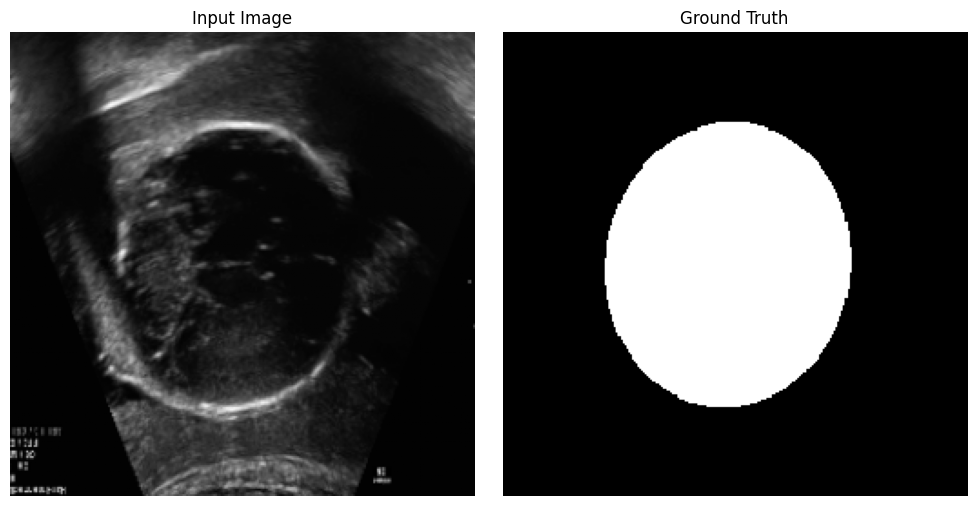

In [ ]:
# Get a batch of training data
sample_images, sample_masks = next(iter(train_loader))

print(f"Sample batch:")
print(f"  Images shape: {sample_images.shape}")
print(f"  Masks shape: {sample_masks.shape}")
print(f"  Image range: [{sample_images.min():.4f}, {sample_images.max():.4f}]")
print(f"  Mask range: [{sample_masks.min():.4f}, {sample_masks.max():.4f}]")
print(f"  Mask unique values: {torch.unique(sample_masks)}")
print(f"  Mask mean (% foreground): {sample_masks.mean():.4f}")

# CRITICAL CHECK: Ensure masks are binary {0, 1}
if not torch.all((sample_masks == 0) | (sample_masks == 1)):
    print("\n⚠️  WARNING: Masks are not binary! Check preprocessing.")
else:
    print("\n✓ Masks are properly binary {0, 1}")

# Check if masks have reasonable foreground ratio (2-10% typical for fetal head)
fg_ratio = sample_masks.mean().item()
if fg_ratio < 0.01 or fg_ratio > 0.3:
    print(f"⚠️  WARNING: Unusual foreground ratio: {fg_ratio:.2%} (expected 2-10%)")
else:
    print(f"✓ Foreground ratio looks reasonable: {fg_ratio:.2%}")

# Visualize first sample
visualize_sample(sample_images[0], sample_masks[0])

## 7. Training and Validation Functions

### train_one_epoch()
- Sets model to training mode
- Iterates through training batches
- Forward pass → loss calculation → backward pass → optimizer step
- Returns average epoch loss

### validate()
- Sets model to evaluation mode (disables dropout, batchnorm updates)
- Computes loss and metrics on validation set
- Model outputs raw logits, applies sigmoid for predictions
- Thresholds at 0.5 for binary predictions
- Calculates: Dice coefficient, IoU, Pixel Accuracy
- Returns average metrics across all validation samples

In [ ]:
print("="*80)
print("MODEL-LOSS COMPATIBILITY VERIFICATION")
print("="*80)

# Test with a small batch
sample_images, sample_masks = next(iter(train_loader))
sample_images = sample_images.to(device)
sample_masks = sample_masks.to(device)

# Forward pass
with torch.no_grad():
    model_outputs = model(sample_images)

print(f"\n1. Model Output Analysis:")
print(f"   Shape: {model_outputs.shape}")
print(f"   Range: [{model_outputs.min().item():.4f}, {model_outputs.max().item():.4f}]")
print(f"   Mean: {model_outputs.mean().item():.4f}")
print(f"   Std: {model_outputs.std().item():.4f}")

# Check if outputs are logits (should have negative values and values > 1)
has_negative = (model_outputs < 0).any().item()
has_large_positive = (model_outputs > 1).any().item()

if has_negative or has_large_positive:
    print(f"   ✓ Outputs are LOGITS (raw values before sigmoid)")
    print(f"     - Has negative values: {has_negative}")
    print(f"     - Has values > 1: {has_large_positive}")
else:
    print(f"   ⚠️  WARNING: Outputs look like probabilities [0,1], not logits!")
    print(f"     - Model may have sigmoid in output layer")

print(f"\n2. Loss Function Test:")
loss_value = criterion(model_outputs, sample_masks)
print(f"   Loss value: {loss_value.item():.6f}")
print(f"   ✓ Loss computed successfully")

print(f"\n3. Validation Metrics Test:")
# Apply sigmoid to get probabilities for metrics
probs = torch.sigmoid(model_outputs)
preds = (probs > 0.5).float()

print(f"   Probabilities after sigmoid:")
print(f"     Range: [{probs.min().item():.4f}, {probs.max().item():.4f}]")
print(f"     Mean: {probs.mean().item():.4f}")

dice = dice_coefficient(preds[0], sample_masks[0]).item()
iou = iou_score(preds[0], sample_masks[0]).item()
pa = pixel_accuracy(preds[0], sample_masks[0])

print(f"   Sample metrics (before training):")
print(f"     Dice: {dice:.4f}")
print(f"     IoU: {iou:.4f}")
print(f"     PA: {pa:.4f}")

print(f"\n{'='*80}")
print(f"✓ ALL CHECKS PASSED - Model and loss are compatible!")
print(f"{'='*80}\n")

MODEL-LOSS COMPATIBILITY VERIFICATION

1. Model Output Analysis:
   Shape: torch.Size([16, 1, 256, 256])
   Range: [-6.2772, 6.3011]
   Mean: 0.1926
   Std: 0.4837
   ✓ Outputs are LOGITS (raw values before sigmoid)
     - Has negative values: True
     - Has values > 1: True

2. Loss Function Test:
[BCEWithLogitsBalancedLoss] Auto-computed pos_weight: 2.42
  Foreground ratio: 29.2503%
  This gives 2.4x more weight to foreground pixels
   Loss value: 0.703394
   ✓ Loss computed successfully

3. Validation Metrics Test:
   Probabilities after sigmoid:
     Range: [0.0019, 0.9982]
     Mean: 0.5451
   Sample metrics (before training):
     Dice: 0.5914
     IoU: 0.4199
     PA: 0.4924

✓ ALL CHECKS PASSED - Model and loss are compatible!



In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(images)  # Model outputs raw logits

        # Calculate loss (DiceBCEWithLogitsLoss expects logits)
        loss = criterion(logits, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss


def validate(model, dataloader, criterion, device, epoch):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    dice_scores = []
    iou_scores = []
    pa_scores = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            logits = model(images)  # Model outputs raw logits

            # Calculate loss (DiceBCEWithLogitsLoss expects logits)
            loss = criterion(logits, masks)
            running_loss += loss.item()

            # Calculate metrics
            # Apply sigmoid to convert logits to probabilities [0, 1]
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            for i in range(images.size(0)):
                dice = dice_coefficient(preds[i], masks[i])
                iou = iou_score(preds[i], masks[i])
                pa = pixel_accuracy(preds[i], masks[i])

                dice_scores.append(dice.item())
                iou_scores.append(iou.item())
                pa_scores.append(pa.item())

            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'dice': f"{np.mean(dice_scores):.4f}"
            })

    # Calculate average metrics
    val_loss = running_loss / len(dataloader)
    val_dice = np.mean(dice_scores)
    val_iou = np.mean(iou_scores)
    val_pa = np.mean(pa_scores)

    return val_loss, val_dice, val_iou, val_pa


print("Training functions defined!")

Training functions defined!


## 8. Training Loop

### Training Configuration
- **Epochs:** Configurable (typically 50-100)
- **Early Stopping:** Monitors validation Dice coefficient
  - Stops if no improvement for N consecutive epochs
  - Prevents overfitting and saves compute time
- **Model Checkpointing:** Saves best model based on validation Dice

### Per-Epoch Workflow
1. Train on full training set
2. Validate on validation set
3. Update learning rate (ReduceLROnPlateau scheduler)
4. Log metrics: loss, Dice, IoU, pixel accuracy
5. Save model if validation Dice improves
6. Check early stopping criterion

In [ ]:
print(f"{'='*60}")
print(f"Starting Training - MobileNetV2-Based ASPP Residual SE U-Net")
print(f"{'='*60}")

# Training configuration
num_epochs = config['training']['num_epochs']
patience = config['training']['early_stopping_patience']

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'val_pa': [],
    'lr': []
}

best_dice = 0.0
epochs_without_improvement = 0

print(f"Epochs: {num_epochs}")
print(f"Early Stopping Patience: {patience}")
print(f"{'='*60}\n")

# Main training loop
for epoch in range(num_epochs):
    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)

    # Validate
    val_loss, val_dice, val_iou, val_pa = validate(model, val_loader, criterion, device, epoch)

    # Update learning rate
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_dice)
    current_lr = optimizer.param_groups[0]['lr']

    # Update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    history['val_pa'].append(val_pa)
    history['lr'].append(current_lr)

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"{'='*100}")
    dice_indicator = ' 🏆' if val_dice > best_dice else ''
    lr_change = f' ⬇️ (reduced from {old_lr:.6f})' if current_lr < old_lr else ''

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}{dice_indicator}")
    print(f"Val mIoU: {val_iou:.4f} | Val mPA: {val_pa:.4f}")
    if lr_change: print(f"LR: {current_lr:.6f}{lr_change}")
    print(f"{'='*100}")

    # Check for improvement
    is_best = val_dice > best_dice
    if is_best:
        best_dice = val_dice
        epochs_without_improvement = 0

        # Save best model
        checkpoint_dir = Path(get_path(config['logging']['checkpoint_dir']))
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
        best_model_path = checkpoint_dir / 'best_model_mobinet_aspp_residual_se.pth'

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_dice': best_dice,
            'history': history,
            'config': config
        }, best_model_path)

        print(f"  → Saved best model (Dice: {best_dice:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"  ⚠️  No improvement for {epochs_without_improvement}/{patience} epochs")

    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"\n{'='*70}")
        print(f"⛔ EARLY STOPPING TRIGGERED")
        print(f"{'='*70}")
        print(f"  Stopped at epoch: {epoch+1}")
        print(f"  Best Dice Score:  {best_dice:.4f}")
        print(f"  Patience limit:   {patience} epochs without improvement")
        print(f"{'='*70}")
        break

# Final summary
print(f"\n{'='*60}")
print(f"Training Completed!")
print(f"{'='*60}")
print(f"Best Validation Dice: {best_dice:.4f}")
print(f"Best Validation IoU:  {max(history['val_iou']):.4f}")
print(f"Best Validation PA:   {max(history['val_pa']):.4f}")
print(f"{'='*60}\n")

Starting Training - ASPP-Enhanced Residual SE U-Net
Epochs: 100
Early Stopping Patience: 15



Epoch 1 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 1/100
Train Loss: 0.2250
Val Loss: 0.1125 | Val Dice: 0.9517 🏆
Val mIoU: 0.9090 | Val mPA: 0.9678
  → Saved best model (Dice: 0.9517)


Epoch 2 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 2/100
Train Loss: 0.0984
Val Loss: 0.0748 | Val Dice: 0.9600 🏆
Val mIoU: 0.9254 | Val mPA: 0.9741
  → Saved best model (Dice: 0.9600)


Epoch 3 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 3/100
Train Loss: 0.0711
Val Loss: 0.0602 | Val Dice: 0.9673 🏆
Val mIoU: 0.9387 | Val mPA: 0.9789
  → Saved best model (Dice: 0.9673)


Epoch 4 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 4/100
Train Loss: 0.0625
Val Loss: 0.0565 | Val Dice: 0.9658
Val mIoU: 0.9344 | Val mPA: 0.9767
  ⚠️  No improvement for 1/15 epochs


Epoch 5 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 5/100
Train Loss: 0.0568
Val Loss: 0.0509 | Val Dice: 0.9685 🏆
Val mIoU: 0.9408 | Val mPA: 0.9795
  → Saved best model (Dice: 0.9685)


Epoch 6 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 6/100
Train Loss: 0.0541
Val Loss: 0.0500 | Val Dice: 0.9688 🏆
Val mIoU: 0.9414 | Val mPA: 0.9797
  → Saved best model (Dice: 0.9688)


Epoch 7 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 7/100
Train Loss: 0.0521
Val Loss: 0.0579 | Val Dice: 0.9657
Val mIoU: 0.9360 | Val mPA: 0.9780
  ⚠️  No improvement for 1/15 epochs


Epoch 8 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 8/100
Train Loss: 0.0536
Val Loss: 0.0518 | Val Dice: 0.9680
Val mIoU: 0.9397 | Val mPA: 0.9793
  ⚠️  No improvement for 2/15 epochs


Epoch 9 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 9/100
Train Loss: 0.0484
Val Loss: 0.0495 | Val Dice: 0.9694 🏆
Val mIoU: 0.9424 | Val mPA: 0.9801
  → Saved best model (Dice: 0.9694)


Epoch 10 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 10/100
Train Loss: 0.0475
Val Loss: 0.0453 | Val Dice: 0.9720 🏆
Val mIoU: 0.9461 | Val mPA: 0.9812
  → Saved best model (Dice: 0.9720)


Epoch 11 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 11/100
Train Loss: 0.0492
Val Loss: 0.0566 | Val Dice: 0.9665
Val mIoU: 0.9363 | Val mPA: 0.9782
  ⚠️  No improvement for 1/15 epochs


Epoch 12 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 12/100
Train Loss: 0.0482
Val Loss: 0.0460 | Val Dice: 0.9704
Val mIoU: 0.9444 | Val mPA: 0.9809
  ⚠️  No improvement for 2/15 epochs


Epoch 13 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 13/100
Train Loss: 0.0469
Val Loss: 0.0468 | Val Dice: 0.9708
Val mIoU: 0.9455 | Val mPA: 0.9814
  ⚠️  No improvement for 3/15 epochs


Epoch 14 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 14/100
Train Loss: 0.0464
Val Loss: 0.0457 | Val Dice: 0.9712
Val mIoU: 0.9457 | Val mPA: 0.9812
  ⚠️  No improvement for 4/15 epochs


Epoch 15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 15/100
Train Loss: 0.0459
Val Loss: 0.0460 | Val Dice: 0.9688
Val mIoU: 0.9416 | Val mPA: 0.9796
  ⚠️  No improvement for 5/15 epochs


Epoch 16 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 16/100
Train Loss: 0.0469
Val Loss: 0.0455 | Val Dice: 0.9697
Val mIoU: 0.9433 | Val mPA: 0.9805
  ⚠️  No improvement for 6/15 epochs


Epoch 17 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 17/100
Train Loss: 0.0442
Val Loss: 0.0471 | Val Dice: 0.9687
Val mIoU: 0.9420 | Val mPA: 0.9800
  ⚠️  No improvement for 7/15 epochs


Epoch 18 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 18/100
Train Loss: 0.0460
Val Loss: 0.0458 | Val Dice: 0.9685
Val mIoU: 0.9411 | Val mPA: 0.9794
  ⚠️  No improvement for 8/15 epochs


Epoch 19 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 19/100
Train Loss: 0.0440
Val Loss: 0.0494 | Val Dice: 0.9664
Val mIoU: 0.9380 | Val mPA: 0.9785
  ⚠️  No improvement for 9/15 epochs


Epoch 20 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 20/100
Train Loss: 0.0430
Val Loss: 0.0470 | Val Dice: 0.9711
Val mIoU: 0.9461 | Val mPA: 0.9815
  ⚠️  No improvement for 10/15 epochs


Epoch 21 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 21/100
Train Loss: 0.0447
Val Loss: 0.0438 | Val Dice: 0.9722 🏆
Val mIoU: 0.9478 | Val mPA: 0.9820
  → Saved best model (Dice: 0.9722)


Epoch 22 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 22/100
Train Loss: 0.0429
Val Loss: 0.0444 | Val Dice: 0.9721
Val mIoU: 0.9475 | Val mPA: 0.9819
  ⚠️  No improvement for 1/15 epochs


Epoch 23 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 23/100
Train Loss: 0.0474
Val Loss: 0.0447 | Val Dice: 0.9721
Val mIoU: 0.9461 | Val mPA: 0.9811
  ⚠️  No improvement for 2/15 epochs


Epoch 24 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 24/100
Train Loss: 0.0444
Val Loss: 0.0450 | Val Dice: 0.9712
Val mIoU: 0.9457 | Val mPA: 0.9812
  ⚠️  No improvement for 3/15 epochs


Epoch 25 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 25/100
Train Loss: 0.0456
Val Loss: 0.0434 | Val Dice: 0.9705
Val mIoU: 0.9442 | Val mPA: 0.9803
  ⚠️  No improvement for 4/15 epochs


Epoch 26 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 26/100
Train Loss: 0.0426
Val Loss: 0.0451 | Val Dice: 0.9708
Val mIoU: 0.9441 | Val mPA: 0.9804
  ⚠️  No improvement for 5/15 epochs


Epoch 27 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 27/100
Train Loss: 0.0420
Val Loss: 0.0425 | Val Dice: 0.9721
Val mIoU: 0.9475 | Val mPA: 0.9820
  ⚠️  No improvement for 6/15 epochs


Epoch 28 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 28/100
Train Loss: 0.0416
Val Loss: 0.0451 | Val Dice: 0.9718
Val mIoU: 0.9468 | Val mPA: 0.9817
  ⚠️  No improvement for 7/15 epochs


Epoch 29 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 29/100
Train Loss: 0.0443
Val Loss: 0.0429 | Val Dice: 0.9726 🏆
Val mIoU: 0.9477 | Val mPA: 0.9819
  → Saved best model (Dice: 0.9726)


Epoch 30 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 30/100
Train Loss: 0.0433
Val Loss: 0.0412 | Val Dice: 0.9720
Val mIoU: 0.9462 | Val mPA: 0.9812
  ⚠️  No improvement for 1/15 epochs


Epoch 31 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 31/100
Train Loss: 0.0413
Val Loss: 0.0423 | Val Dice: 0.9728 🏆
Val mIoU: 0.9488 | Val mPA: 0.9823
  → Saved best model (Dice: 0.9728)


Epoch 32 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 32/100
Train Loss: 0.0408
Val Loss: 0.0422 | Val Dice: 0.9726
Val mIoU: 0.9484 | Val mPA: 0.9822
  ⚠️  No improvement for 1/15 epochs


Epoch 33 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 33/100
Train Loss: 0.0414
Val Loss: 0.0430 | Val Dice: 0.9721
Val mIoU: 0.9472 | Val mPA: 0.9818
  ⚠️  No improvement for 2/15 epochs


Epoch 34 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 34/100
Train Loss: 0.0414
Val Loss: 0.0434 | Val Dice: 0.9709
Val mIoU: 0.9453 | Val mPA: 0.9811
  ⚠️  No improvement for 3/15 epochs


Epoch 35 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 35/100
Train Loss: 0.0406
Val Loss: 0.0412 | Val Dice: 0.9723
Val mIoU: 0.9470 | Val mPA: 0.9817
  ⚠️  No improvement for 4/15 epochs


Epoch 36 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 36 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 36/100
Train Loss: 0.0406
Val Loss: 0.0405 | Val Dice: 0.9734 🏆
Val mIoU: 0.9485 | Val mPA: 0.9820
  → Saved best model (Dice: 0.9734)


Epoch 37 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 37 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 37/100
Train Loss: 0.0422
Val Loss: 0.0423 | Val Dice: 0.9723
Val mIoU: 0.9477 | Val mPA: 0.9820
  ⚠️  No improvement for 1/15 epochs


Epoch 38 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 38 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 38/100
Train Loss: 0.0408
Val Loss: 0.0421 | Val Dice: 0.9713
Val mIoU: 0.9454 | Val mPA: 0.9810
  ⚠️  No improvement for 2/15 epochs


Epoch 39 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 39 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 39/100
Train Loss: 0.0404
Val Loss: 0.0428 | Val Dice: 0.9724
Val mIoU: 0.9477 | Val mPA: 0.9819
  ⚠️  No improvement for 3/15 epochs


Epoch 40 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 40 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 40/100
Train Loss: 0.0411
Val Loss: 0.0442 | Val Dice: 0.9714
Val mIoU: 0.9462 | Val mPA: 0.9815
  ⚠️  No improvement for 4/15 epochs


Epoch 41 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 41 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 41/100
Train Loss: 0.0421
Val Loss: 0.0420 | Val Dice: 0.9731
Val mIoU: 0.9492 | Val mPA: 0.9824
  ⚠️  No improvement for 5/15 epochs


Epoch 42 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 42 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 42/100
Train Loss: 0.0401
Val Loss: 0.0419 | Val Dice: 0.9725
Val mIoU: 0.9481 | Val mPA: 0.9821
  ⚠️  No improvement for 6/15 epochs


Epoch 43 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 43 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 43/100
Train Loss: 0.0393
Val Loss: 0.0403 | Val Dice: 0.9737 🏆
Val mIoU: 0.9494 | Val mPA: 0.9825
  → Saved best model (Dice: 0.9737)


Epoch 44 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 44 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 44/100
Train Loss: 0.0400
Val Loss: 0.0419 | Val Dice: 0.9711
Val mIoU: 0.9446 | Val mPA: 0.9806
  ⚠️  No improvement for 1/15 epochs


Epoch 45 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 45 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 45/100
Train Loss: 0.0396
Val Loss: 0.0413 | Val Dice: 0.9726
Val mIoU: 0.9480 | Val mPA: 0.9820
  ⚠️  No improvement for 2/15 epochs


Epoch 46 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 46 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 46/100
Train Loss: 0.0414
Val Loss: 0.0421 | Val Dice: 0.9723
Val mIoU: 0.9468 | Val mPA: 0.9811
  ⚠️  No improvement for 3/15 epochs


Epoch 47 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 47 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 47/100
Train Loss: 0.0414
Val Loss: 0.0393 | Val Dice: 0.9742 🏆
Val mIoU: 0.9503 | Val mPA: 0.9827
  → Saved best model (Dice: 0.9742)


Epoch 48 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 48 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 48/100
Train Loss: 0.0399
Val Loss: 0.0405 | Val Dice: 0.9732
Val mIoU: 0.9481 | Val mPA: 0.9819
  ⚠️  No improvement for 1/15 epochs


Epoch 49 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 49 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 49/100
Train Loss: 0.0393
Val Loss: 0.0390 | Val Dice: 0.9745 🏆
Val mIoU: 0.9506 | Val mPA: 0.9826
  → Saved best model (Dice: 0.9745)


Epoch 50 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 50/100
Train Loss: 0.0395
Val Loss: 0.0406 | Val Dice: 0.9733
Val mIoU: 0.9489 | Val mPA: 0.9824
  ⚠️  No improvement for 1/15 epochs


Epoch 51 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 51 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 51/100
Train Loss: 0.0397
Val Loss: 0.0395 | Val Dice: 0.9739
Val mIoU: 0.9495 | Val mPA: 0.9822
  ⚠️  No improvement for 2/15 epochs


Epoch 52 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 52 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 52/100
Train Loss: 0.0400
Val Loss: 0.0411 | Val Dice: 0.9719
Val mIoU: 0.9459 | Val mPA: 0.9810
  ⚠️  No improvement for 3/15 epochs


Epoch 53 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 53 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 53/100
Train Loss: 0.0390
Val Loss: 0.0411 | Val Dice: 0.9728
Val mIoU: 0.9488 | Val mPA: 0.9823
  ⚠️  No improvement for 4/15 epochs


Epoch 54 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 54 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 54/100
Train Loss: 0.0389
Val Loss: 0.0400 | Val Dice: 0.9732
Val mIoU: 0.9485 | Val mPA: 0.9823
  ⚠️  No improvement for 5/15 epochs


Epoch 55 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 55 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 55/100
Train Loss: 0.0398
Val Loss: 0.0405 | Val Dice: 0.9733
Val mIoU: 0.9484 | Val mPA: 0.9820
  ⚠️  No improvement for 6/15 epochs


Epoch 56 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 56 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 56/100
Train Loss: 0.0402
Val Loss: 0.0402 | Val Dice: 0.9728
Val mIoU: 0.9474 | Val mPA: 0.9815
  ⚠️  No improvement for 7/15 epochs


Epoch 57 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 57 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 57/100
Train Loss: 0.0393
Val Loss: 0.0386 | Val Dice: 0.9744
Val mIoU: 0.9504 | Val mPA: 0.9827
  ⚠️  No improvement for 8/15 epochs


Epoch 58 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 58 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 58/100
Train Loss: 0.0389
Val Loss: 0.0418 | Val Dice: 0.9726
Val mIoU: 0.9476 | Val mPA: 0.9819
  ⚠️  No improvement for 9/15 epochs


Epoch 59 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 59 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 59/100
Train Loss: 0.0396
Val Loss: 0.0388 | Val Dice: 0.9741
Val mIoU: 0.9500 | Val mPA: 0.9825
  ⚠️  No improvement for 10/15 epochs


Epoch 60 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 60 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 60/100
Train Loss: 0.0398
Val Loss: 0.0442 | Val Dice: 0.9712
Val mIoU: 0.9466 | Val mPA: 0.9817
LR: 0.000150 ⬇️ (reduced from 0.000300)
  ⚠️  No improvement for 11/15 epochs


Epoch 61 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 61 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 61/100
Train Loss: 0.0382
Val Loss: 0.0383 | Val Dice: 0.9745
Val mIoU: 0.9508 | Val mPA: 0.9828
  ⚠️  No improvement for 12/15 epochs


Epoch 62 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 62 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 62/100
Train Loss: 0.0371
Val Loss: 0.0390 | Val Dice: 0.9740
Val mIoU: 0.9502 | Val mPA: 0.9827
  ⚠️  No improvement for 13/15 epochs


Epoch 63 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 63 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 63/100
Train Loss: 0.0370
Val Loss: 0.0404 | Val Dice: 0.9735
Val mIoU: 0.9500 | Val mPA: 0.9828
  ⚠️  No improvement for 14/15 epochs


Epoch 64 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Epoch 64 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]


Epoch 64/100
Train Loss: 0.0365
Val Loss: 0.0398 | Val Dice: 0.9740
Val mIoU: 0.9506 | Val mPA: 0.9829
  ⚠️  No improvement for 15/15 epochs

⛔ EARLY STOPPING TRIGGERED
  Stopped at epoch: 64
  Best Dice Score:  0.9745
  Patience limit:   15 epochs without improvement

Training Completed!
Best Validation Dice: 0.9745
Best Validation IoU:  0.9508
Best Validation PA:   0.9829



## 9. Training Visualization

Generate plots to analyze training dynamics and convergence:
- **Loss curves:** Training vs validation loss over epochs
- **Dice coefficient:** Validation performance trend
- **IoU score:** Intersection over Union metric progression
- **Learning rate:** ReduceLROnPlateau schedule adjustments

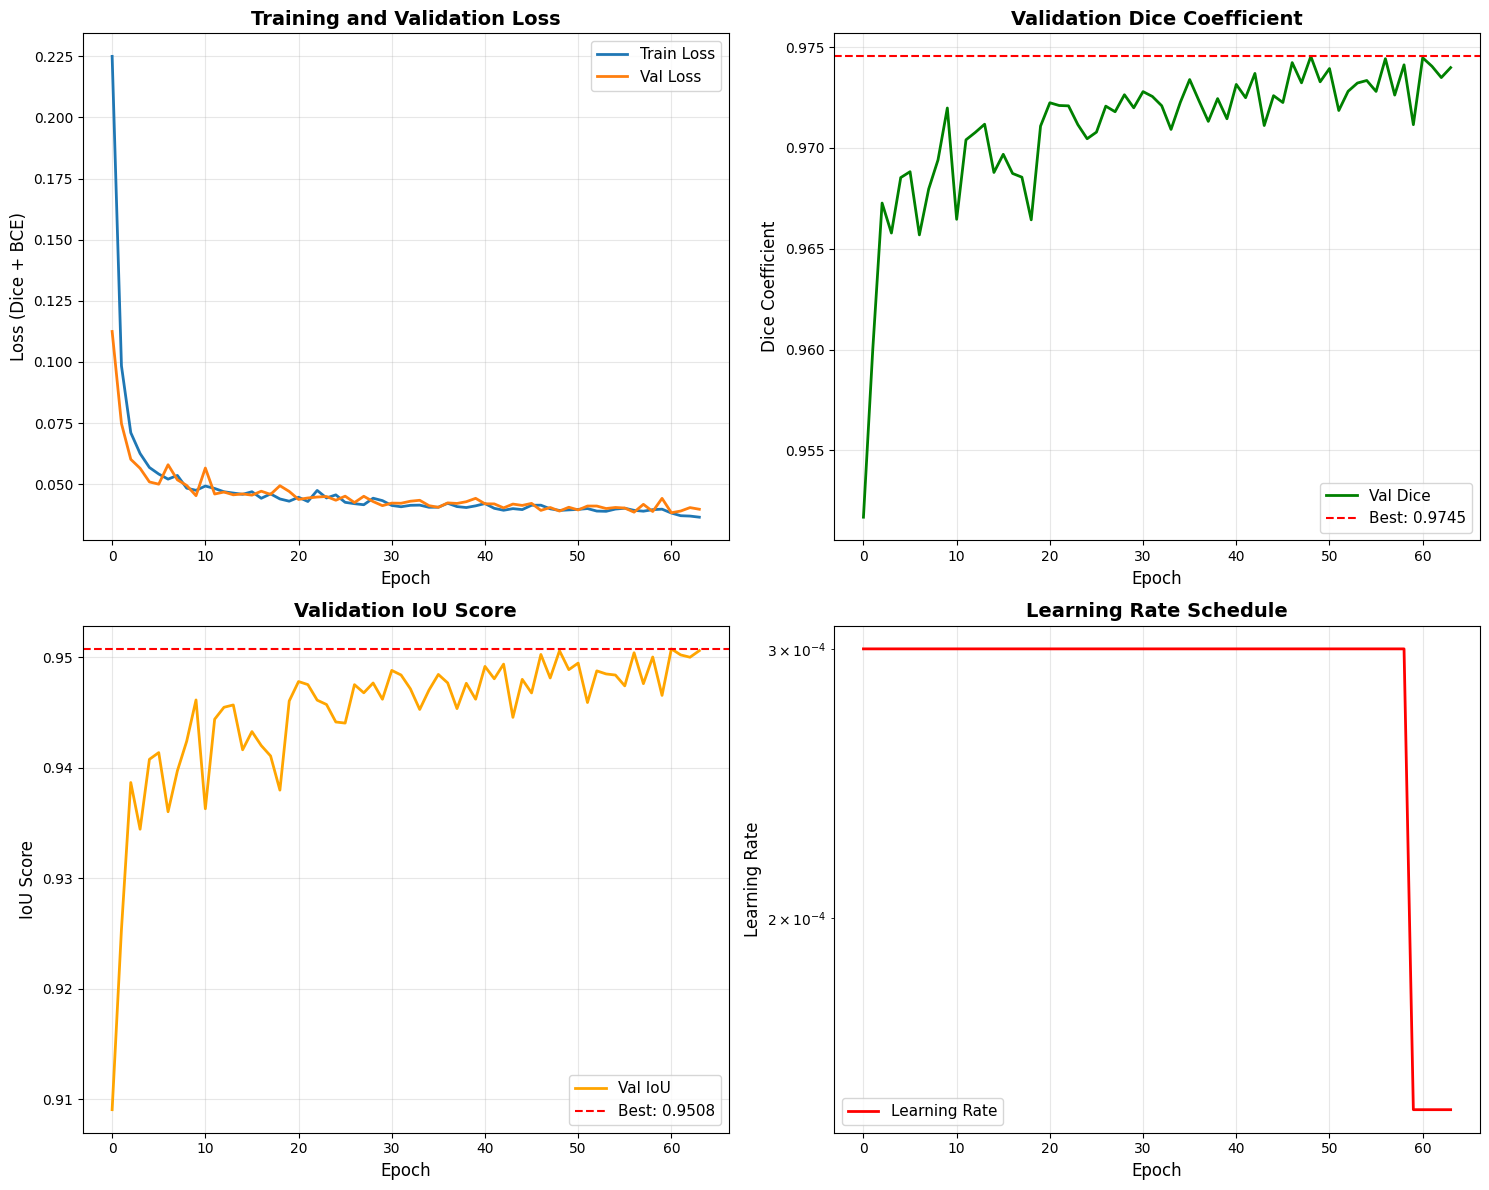

Training curves saved to /content/outputs/results/logs/training_curves.png


<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss (Dice + BCE)', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Dice coefficient
axes[0, 1].plot(history['val_dice'], label='Val Dice', color='green', linewidth=2)
axes[0, 1].axhline(y=best_dice, color='red', linestyle='--', label=f'Best: {best_dice:.4f}')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Dice Coefficient', fontsize=12)
axes[0, 1].set_title('Validation Dice Coefficient', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# IoU
axes[1, 0].plot(history['val_iou'], label='Val IoU', color='orange', linewidth=2)
axes[1, 0].axhline(y=max(history['val_iou']), color='red', linestyle='--',
                   label=f"Best: {max(history['val_iou']):.4f}")
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('IoU Score', fontsize=12)
axes[1, 0].set_title('Validation IoU Score', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Learning rate
axes[1, 1].plot(history['lr'], label='Learning Rate', color='red', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

# Save figure
log_dir = Path(get_path(config['logging']['log_dir']))
log_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(log_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
print(f"Training curves saved to {log_dir / 'training_curves.png'}")

## 10. Model Inference and Results

### Evaluation on Test Set

Load the best checkpoint (highest validation Dice) and visualize predictions:
- Compare input images, ground truth masks, and model predictions
- Calculate per-sample metrics (Dice, IoU, Pixel Accuracy)
- Assess segmentation quality visually

**Note:** Model outputs raw logits. Apply sigmoid to get probabilities [0, 1], then threshold at 0.5 for binary predictions.

Loaded best model from epoch 49
Best Dice Score: 0.9745


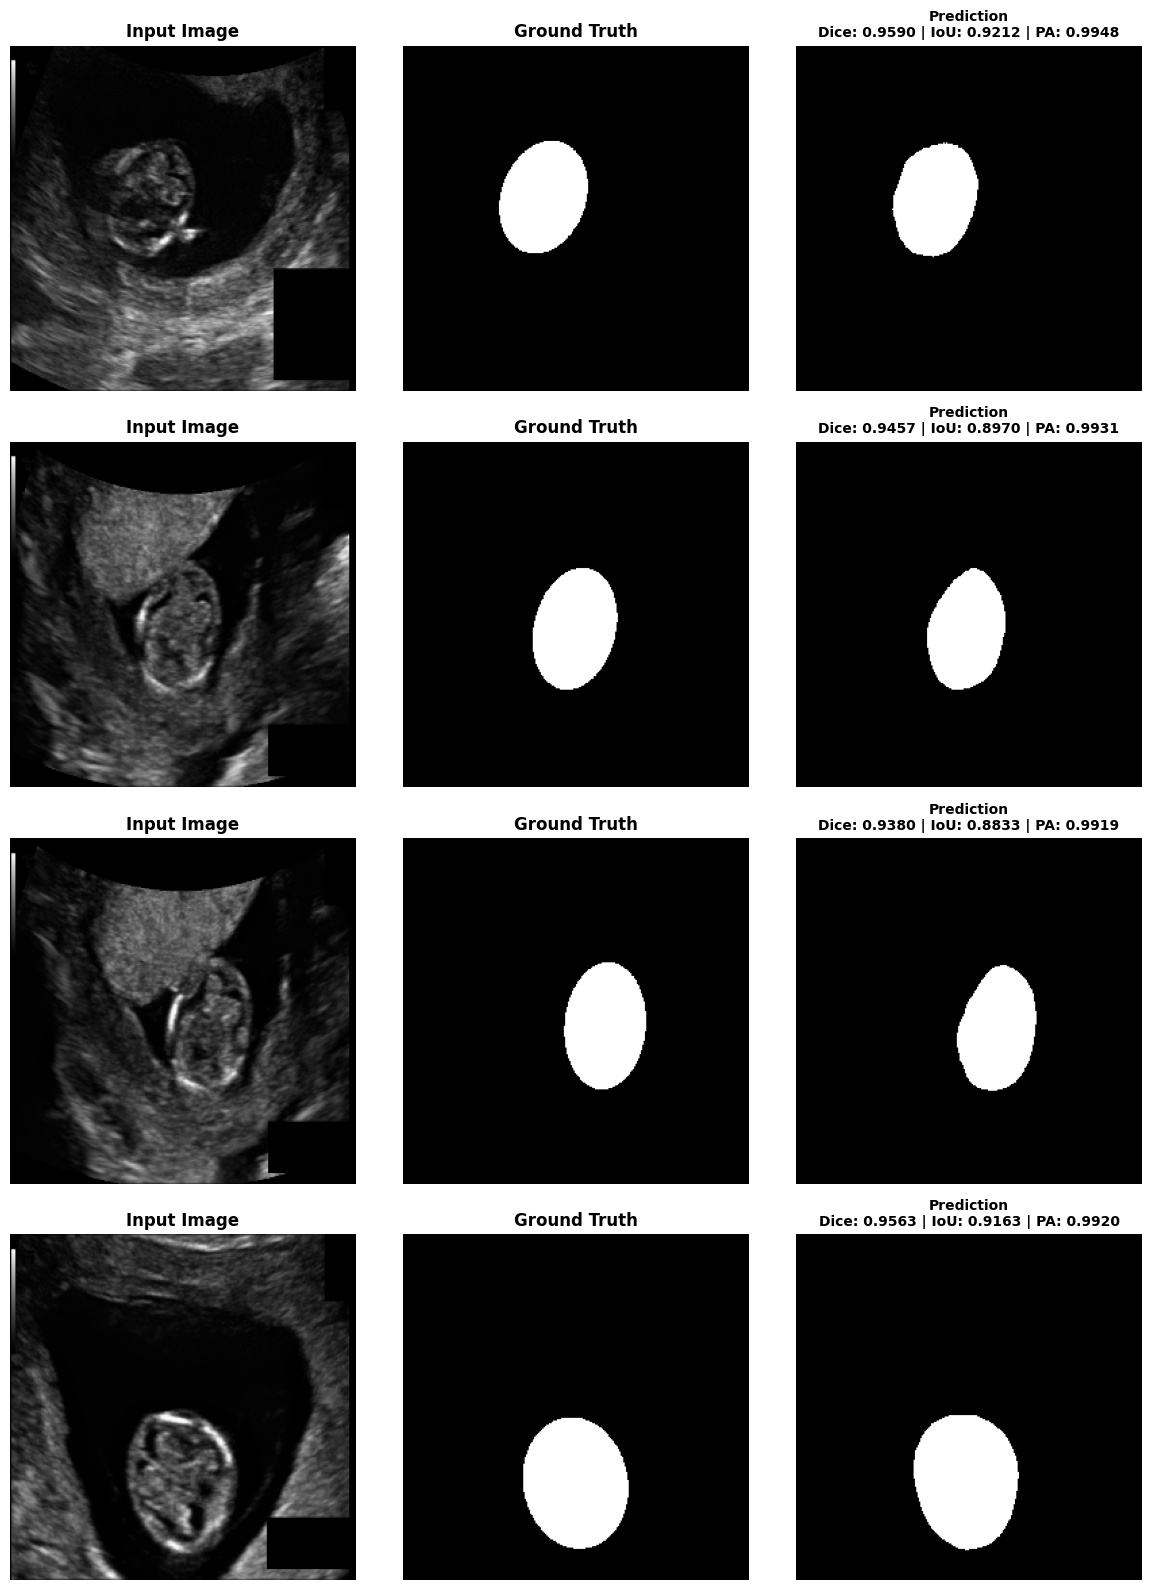

Sample predictions saved to /content/outputs/results/predictions/sample_predictions.png


In [ ]:
# Load best model
checkpoint_path = Path(get_path(config['logging']['checkpoint_dir'])) / 'best_model_mobinet_aspp_residual_se.pth'
checkpoint = torch.load(checkpoint_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best Dice Score: {checkpoint['best_dice']:.4f}")

# Get test samples
test_images, test_masks = next(iter(test_loader))
test_images = test_images.to(device)

# Generate predictions
with torch.no_grad():
    # Model outputs raw logits - apply sigmoid to get probabilities
    test_logits = model(test_images)
    test_probs = torch.sigmoid(test_logits)  # Convert logits to [0, 1] probabilities
    test_preds = (test_probs > 0.5).float()  # Threshold at 0.5

# Visualize predictions
num_samples = min(4, len(test_images))
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    # Move to CPU and convert to numpy
    img = test_images[i, 0].cpu().numpy()
    mask = test_masks[i, 0].numpy()
    pred = test_preds[i, 0].cpu().numpy()

    # Calculate metrics for this sample (ensure both tensors on same device)
    pred_tensor = test_preds[i].cpu()
    mask_tensor = test_masks[i].to(pred_tensor.device)
    dice = dice_coefficient(pred_tensor, mask_tensor).item()
    iou = iou_score(pred_tensor, mask_tensor).item()
    pa = pixel_accuracy(pred_tensor, mask_tensor)

    # Input image
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title('Input Image', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')

    # Ground truth
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[i, 1].axis('off')

    # Prediction
    axes[i, 2].imshow(pred, cmap='gray')
    axes[i, 2].set_title(f'Prediction\nDice: {dice:.4f} | IoU: {iou:.4f} | PA: {pa:.4f}',
                         fontsize=10, fontweight='bold')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Save predictions
pred_dir = Path(get_path(config['logging']['prediction_dir']))
pred_dir.mkdir(parents=True, exist_ok=True)
save_prediction_grid(test_images[:4].cpu(), test_masks[:4], test_preds[:4].cpu(),
                    str(pred_dir / 'sample_predictions.png'), num_samples=4)
print(f"Sample predictions saved to {pred_dir / 'sample_predictions.png'}")